import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
from sklearn.metrics import confusion_matrix
import seaborn as sn
from operator import itemgetter 
import pandas as pd
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch_cls import *
from utils.trainval_cls import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step005_clsMasking_P004_alex' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:2'
print(device)

freqShow = 100

#model parameters
batch_size = 24
newSize = [128, 128]
total_epoch_num = 500  # total number of epoch in training
base_lr = 0.0005      # base learning rate/

cuda:2


In [3]:
with open('dbinfo_cls.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)


cls_datasets = {set_name: PollenCls(dbinfo, size=[128, 128], set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

42115 4720


In [4]:
data_sampler = iter(dataloaders['test'])

In [5]:
data = next(data_sampler)
image, segMask, label = data

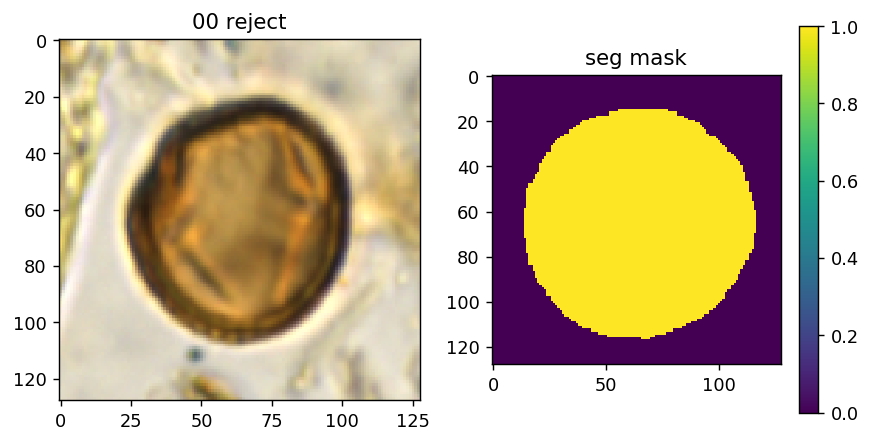

In [6]:
idx = 11
tmplabel = label[idx].squeeze().cpu().detach().numpy()
tmplabel = round(tmplabel.item())
labelName = dbinfo['meta'][tmplabel-1]


numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(8, 4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('{:02d} '.format(tmplabel)+labelName)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = segMask[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')
plt.colorbar()

In [7]:
max(dbinfo['perClassCount']), min(dbinfo['perClassCount'])

(10055, 86)

Text(0, 0.5, 'number in train set')

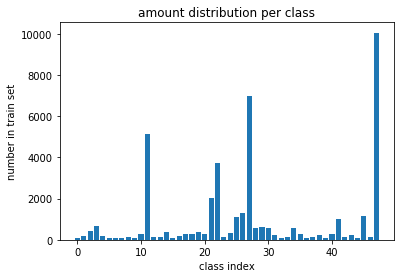

In [8]:
plt.bar(list(range(48)), dbinfo['perClassCount'])
plt.title('amount distribution per class')
plt.xlabel('class index')
plt.ylabel('number in train set')

In [9]:
################## init model ###################
path_to_save_paramOnly = path.join('./exp', project_name, 'bestValModel.paramOnly')
curmodel = PollenClsNet(0, modelName='alex', pretrained=False)
curmodel.load_state_dict(torch.load(path_to_save_paramOnly, map_location='cpu'))

curmodel.to(device);

curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

image = image.to(device)
label = label.type(torch.long).view(-1).to(device)
outputs = curmodel(image)

False


In [18]:
tmpval = -np.asarray(dbinfo['perClassCount'])
sort_index = np.argsort(tmpval)
top25indices = sort_index[1:26]
top25indices = torch.from_numpy(top25indices)
top25indices = top25indices.sort().values



iterCount, sampleCount = 0, 0
phase = 'test'
grndMat = []
predMat = []
grndLabel = torch.tensor([-1.]).reshape((-1,1))
predLabel = torch.tensor([-1.]).reshape((-1,1))
predLabel_noReject = torch.tensor([-1.]).reshape((-1,1))
grndLabel_noReject = torch.tensor([-1.]).reshape((-1,1))
predLabel_top25 = torch.tensor([-1.]).reshape((-1,1))
grndLabel_top25 = torch.tensor([-1.]).reshape((-1,1))
for sample in dataloaders[phase]: 
    iterCount += 1
    
    image, segMask, label = sample
    label = label.detach().squeeze().cpu().reshape((1,-1))
    
    if iterCount%10==0:
        print('{}/{}'.format(iterCount*image.shape[0], len(cls_datasets['test'])))
    
    image = image.to(device)
    segMask = segMask.to(device)      
    outputs = curmodel(image*segMask)
    
    #grndMat += [label.detach().cpu().numpy()]
    #predMat += [outputs.detach().cpu().numpy()]    
    values, indices = outputs.detach().cpu().max(1)

    grndLabel = torch.cat((grndLabel, label.reshape((-1,1))), 0)
    predLabel = torch.cat((predLabel, indices.reshape((-1,1)).type(torch.float)), 0)
    
    
    values, indices = outputs[:,:-1].detach().cpu().max(1)    
    grndLabel_noReject = torch.cat((grndLabel_noReject, label.reshape((-1,1))), 0)
    predLabel_noReject = torch.cat((predLabel_noReject, indices.reshape((-1,1)).type(torch.float)), 0)
    
    
    
    values, indices = outputs[:,top25indices].detach().cpu().max(1)    
    grndLabel_top25 = torch.cat((grndLabel_top25, label.reshape((-1,1))), 0)
    predLabel_top25 = torch.cat((predLabel_top25, indices.reshape((-1,1)).type(torch.float)), 0)
    #if iterCount == 1:
    #    break
grndLabel = grndLabel[1:]    
predLabel = predLabel[1:]    
grndLabel_noReject = grndLabel_noReject[1:]    
predLabel_noReject = predLabel_noReject[1:]  
grndLabel_top25 = grndLabel_top25[1:]    
predLabel_top25 = predLabel_top25[1:]    

240/4720
480/4720
720/4720
960/4720
1200/4720
1440/4720
1680/4720
1920/4720
2160/4720
2400/4720
2640/4720
2880/4720
3120/4720
3360/4720
3600/4720
3840/4720
4080/4720
4320/4720
4560/4720


In [19]:
resultDict = {}
resultDict['grndLabel'] = grndLabel 
resultDict['predLabel'] = predLabel
resultDict['grndLabel_noReject'] = grndLabel_noReject
resultDict['predLabel_noReject'] = predLabel_noReject
resultDict['grndLabel_top25'] = grndLabel_top25
resultDict['predLabel_top25'] = predLabel_top25

with open(path.join('./result', project_name+'.plk'), 'wb') as handle:
    pickle.dump(resultDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
A = grndLabel.numpy()
B = predLabel.numpy()

accList = A-B
accList = (accList==0).astype(np.float32)
acc = accList.mean()
print(acc)

confMat = confusion_matrix(A, B)

a = confMat.sum(axis=1).reshape((-1,1))
confMat = confMat / a
confMat = (confMat * 100).round()/100

0.5947034


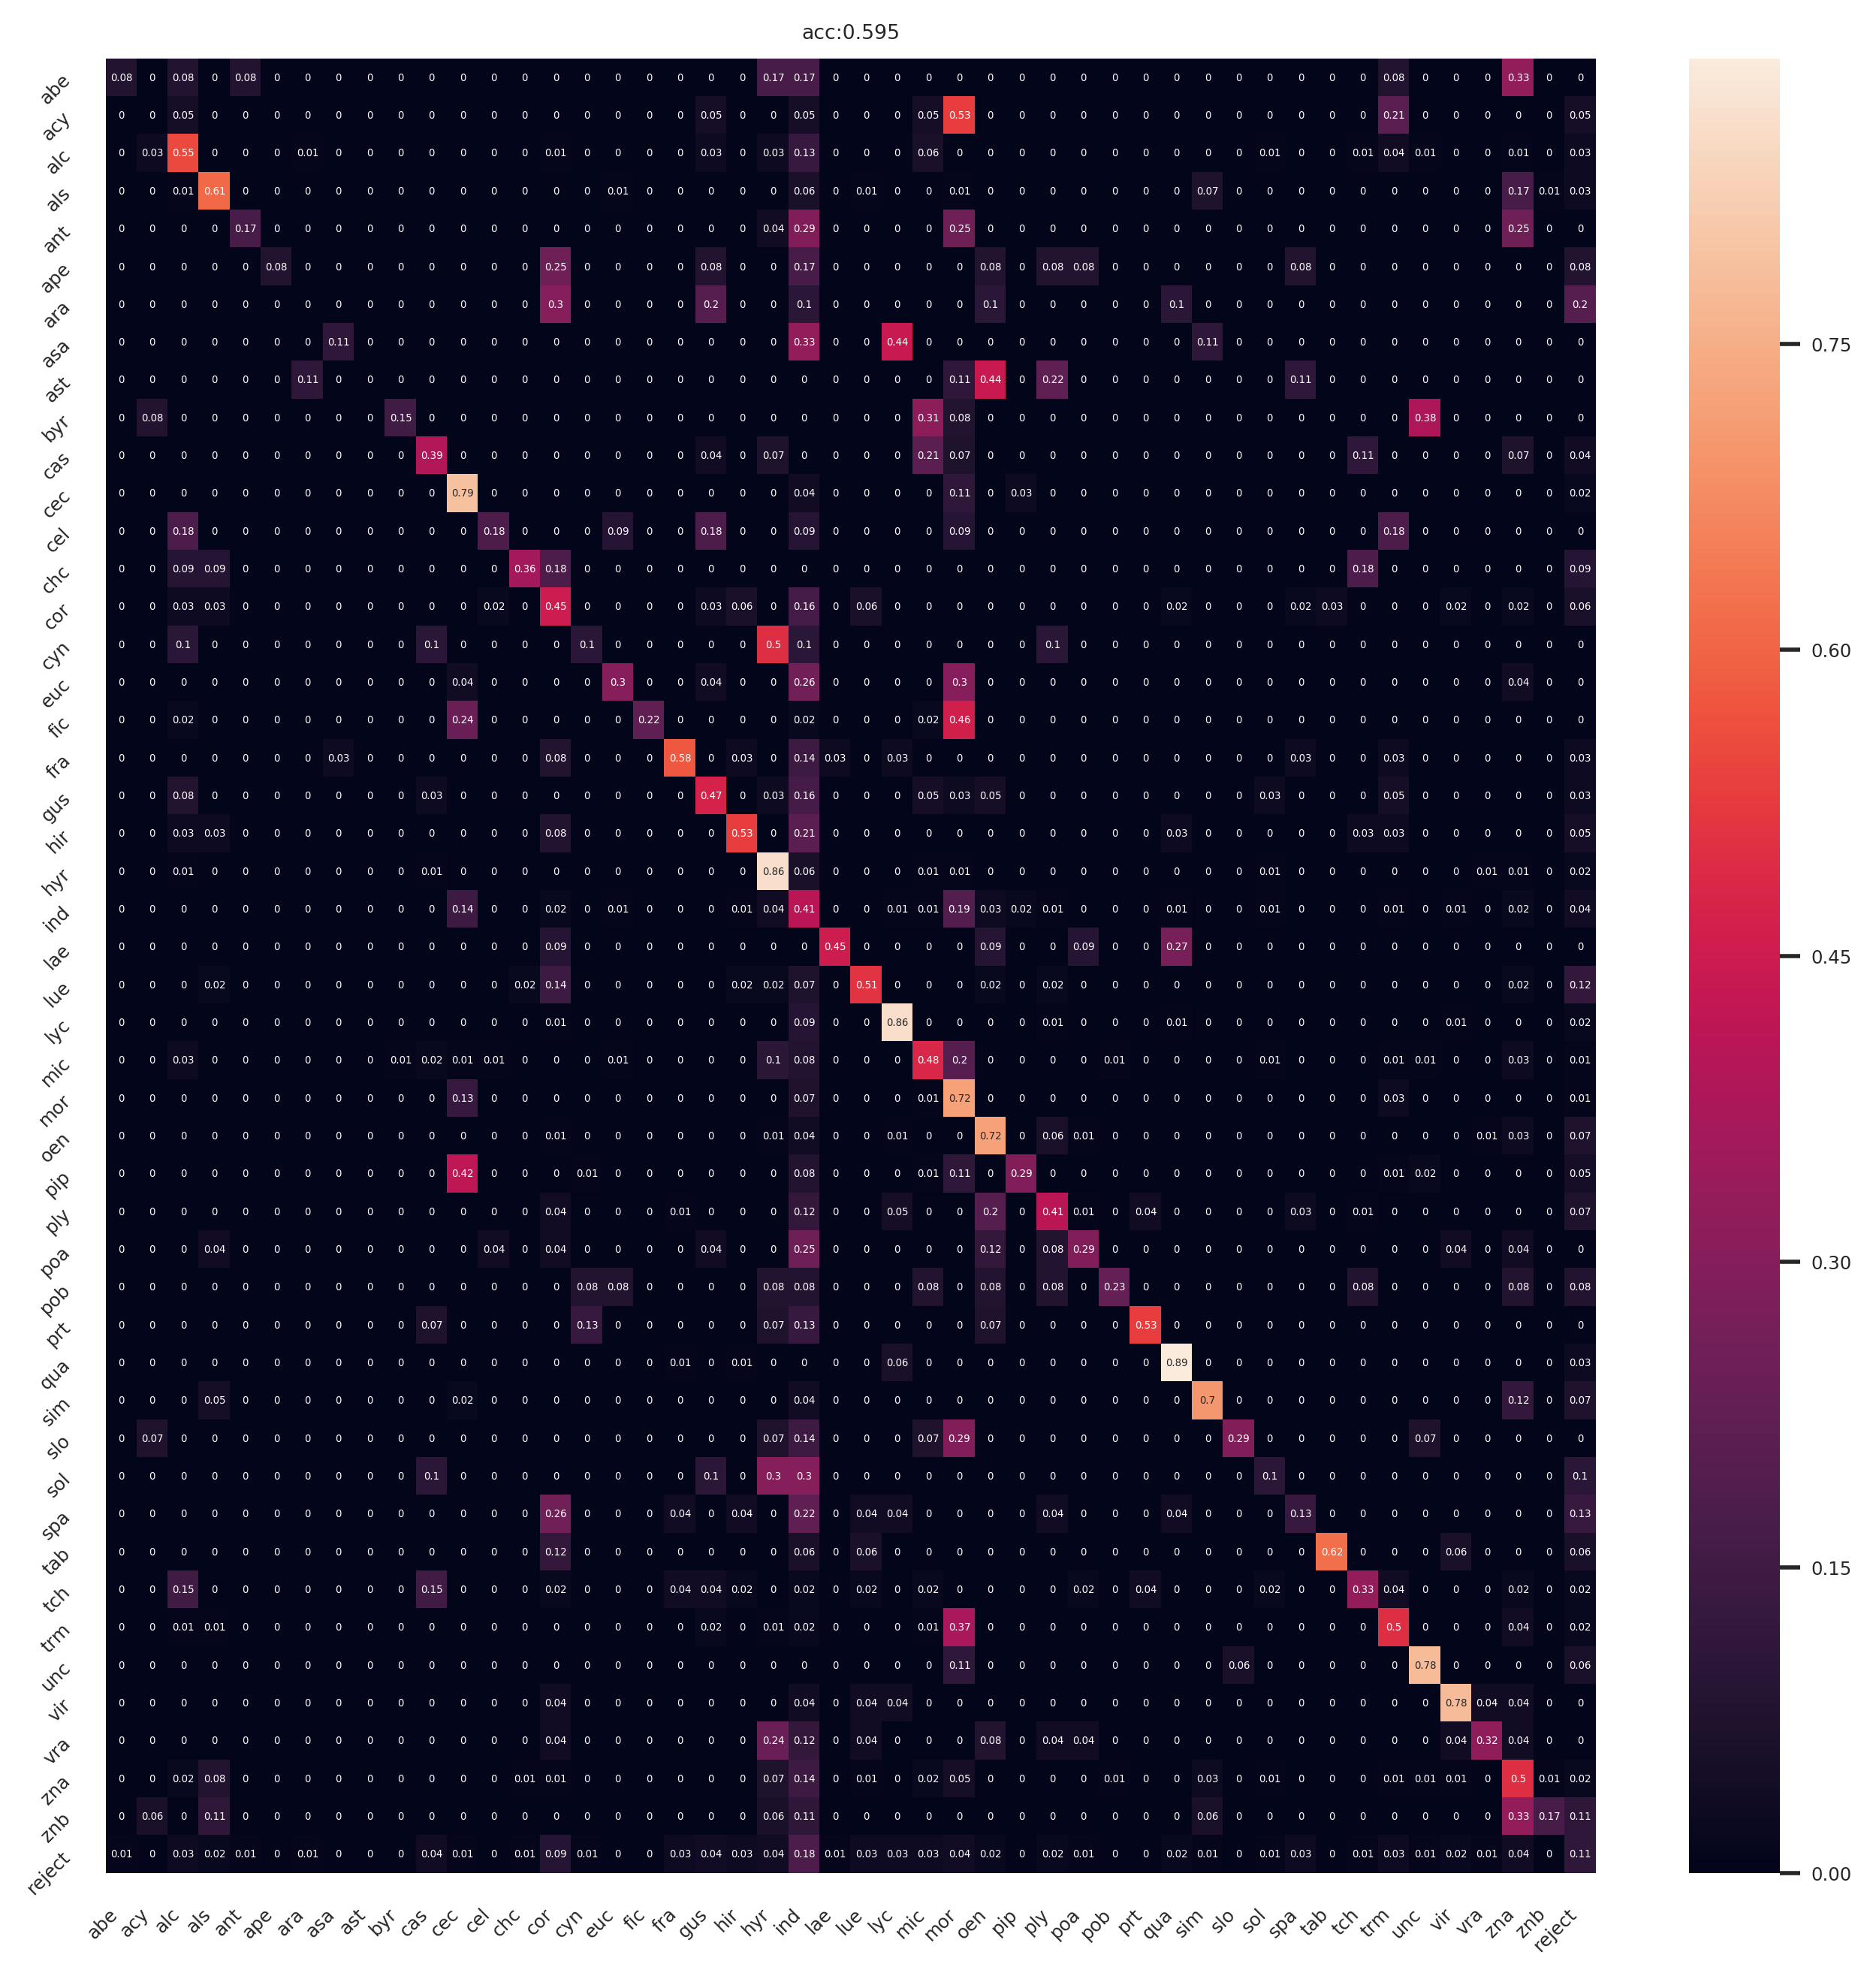

In [21]:
plt.figure(figsize=(10, 10), dpi=320, facecolor='w', edgecolor='k') # figsize -- inch-by-inch

df_cm = pd.DataFrame(confMat, dbinfo['meta'], dbinfo['meta'])

#df_cm.plot(kind='bar',alpha=0.75, rot=0)

#plt.figure(figsize = (10,7))
sn.set(font_scale=0.5)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 3})# font size


# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.title('acc:{:.3f}'.format(acc))

plt.savefig(path.join('./result', project_name+'_allClasses.png'), dpi=320)
plt.show() # ta-da!

excluding "reject" class
-----

In [22]:
B_noReject = predLabel_noReject[grndLabel_noReject!=47]
A_noReject = grndLabel_noReject[grndLabel_noReject!=47]

print(A_noReject.shape, B_noReject.shape)

A_noReject = A_noReject.numpy()
B_noReject = B_noReject.numpy()

accList = A_noReject-B_noReject
accList = (accList==0).astype(np.float32)
acc = accList.mean()
print(acc)

confMat = confusion_matrix(A_noReject, B_noReject)

torch.Size([4535]) torch.Size([4535])
0.6235943


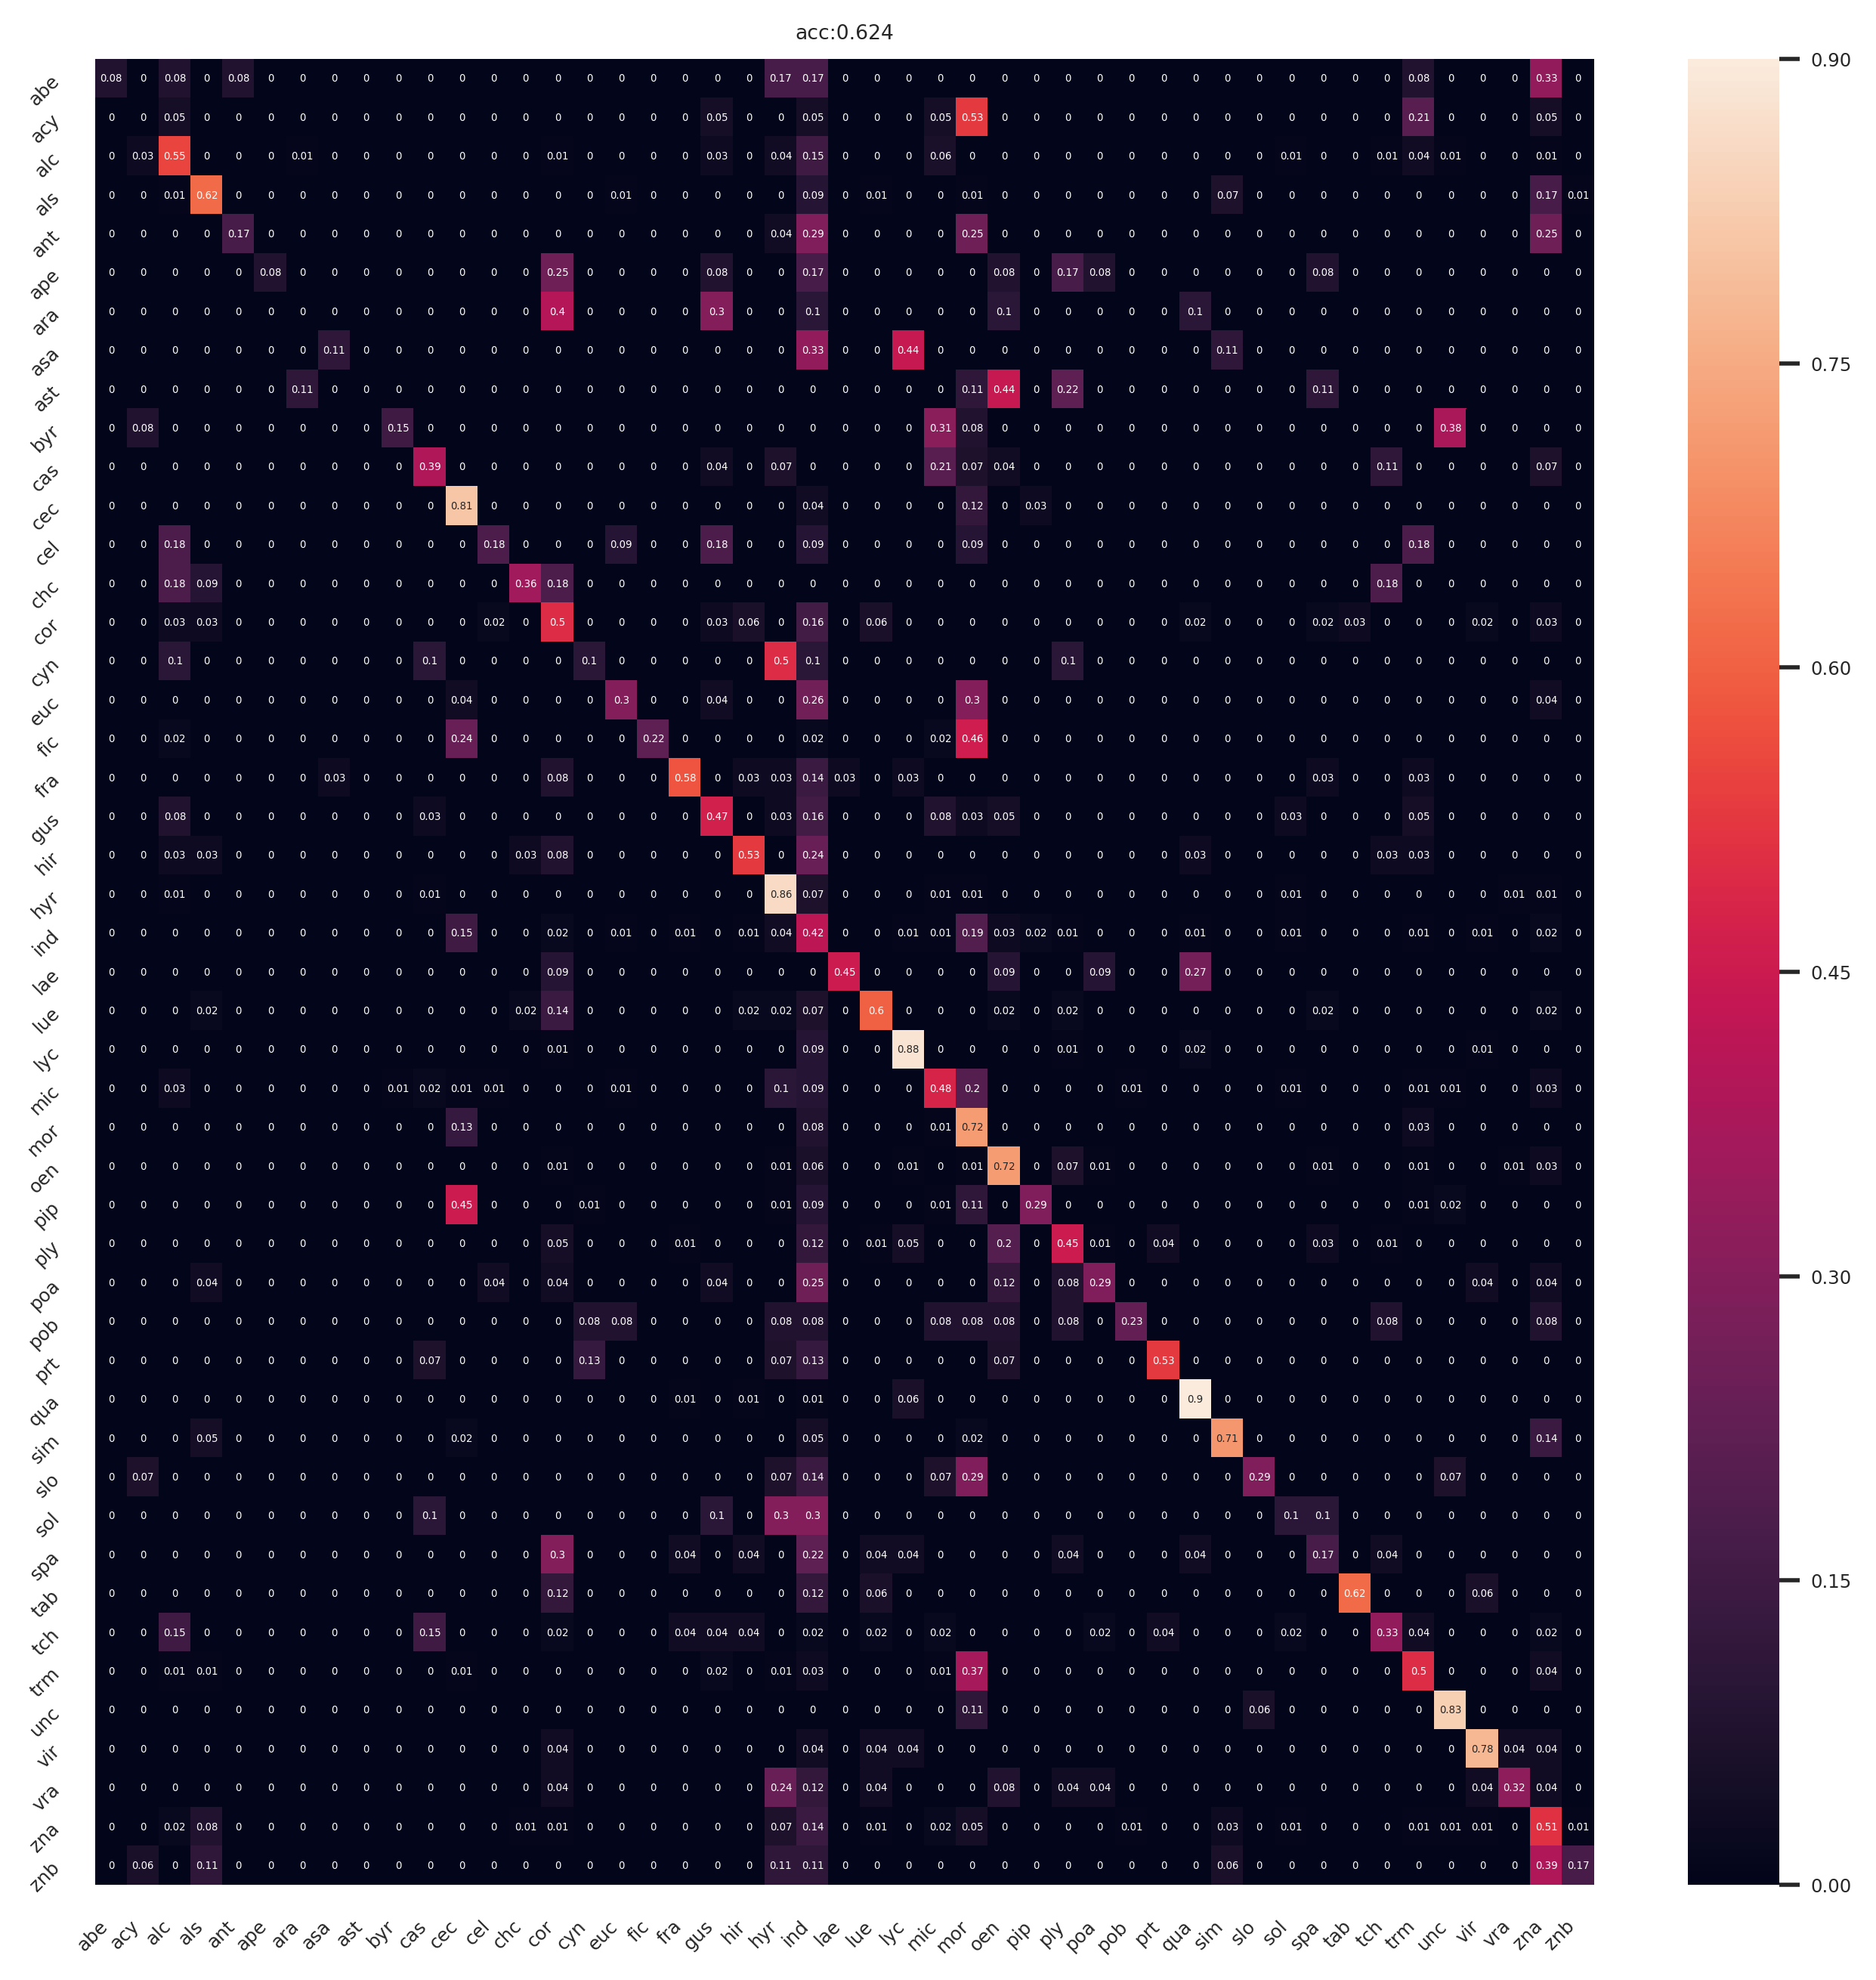

In [23]:
a = confMat.sum(axis=1).reshape((-1,1))
confMat = confMat / a
confMat = (confMat * 100).round()/100


plt.figure(figsize=(10, 10), dpi=320, facecolor='w', edgecolor='k') # figsize -- inch-by-inch

df_cm = pd.DataFrame(confMat, dbinfo['meta'][:-1], dbinfo['meta'][:-1])

#df_cm.plot(kind='bar',alpha=0.75, rot=0)

#plt.figure(figsize = (10,7))
sn.set(font_scale=0.5)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 3})# font size


# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.title('acc:{:.3f}'.format(acc))

plt.savefig(path.join('./result', project_name+'_withoutRejectClass.png'), dpi=320)
plt.show() # ta-da!

top-25 abundant classes
-----

In [24]:
a = []
for i in range(len(grndLabel_top25)):
    if int(grndLabel_top25[i].item()) in top25indices:
        a += [i]

B_top25 = predLabel_top25[a]
A_top25 = grndLabel_top25[a]


top25indicesList = top25indices.cpu().numpy().tolist()
for i in range(len(A_top25)):
    elm = A_top25[i]
    A_top25[i] = top25indicesList.index(elm)        
        

print(A_top25.shape, B_top25.shape)

A_top25 = A_top25.numpy()
B_top25 = B_top25.numpy()

accList = A_top25-B_top25
accList = (accList==0).astype(np.float32)
acc = accList.mean()
print(acc)

confMat = confusion_matrix(A_top25, B_top25)

torch.Size([4208, 1]) torch.Size([4208, 1])
0.6587452


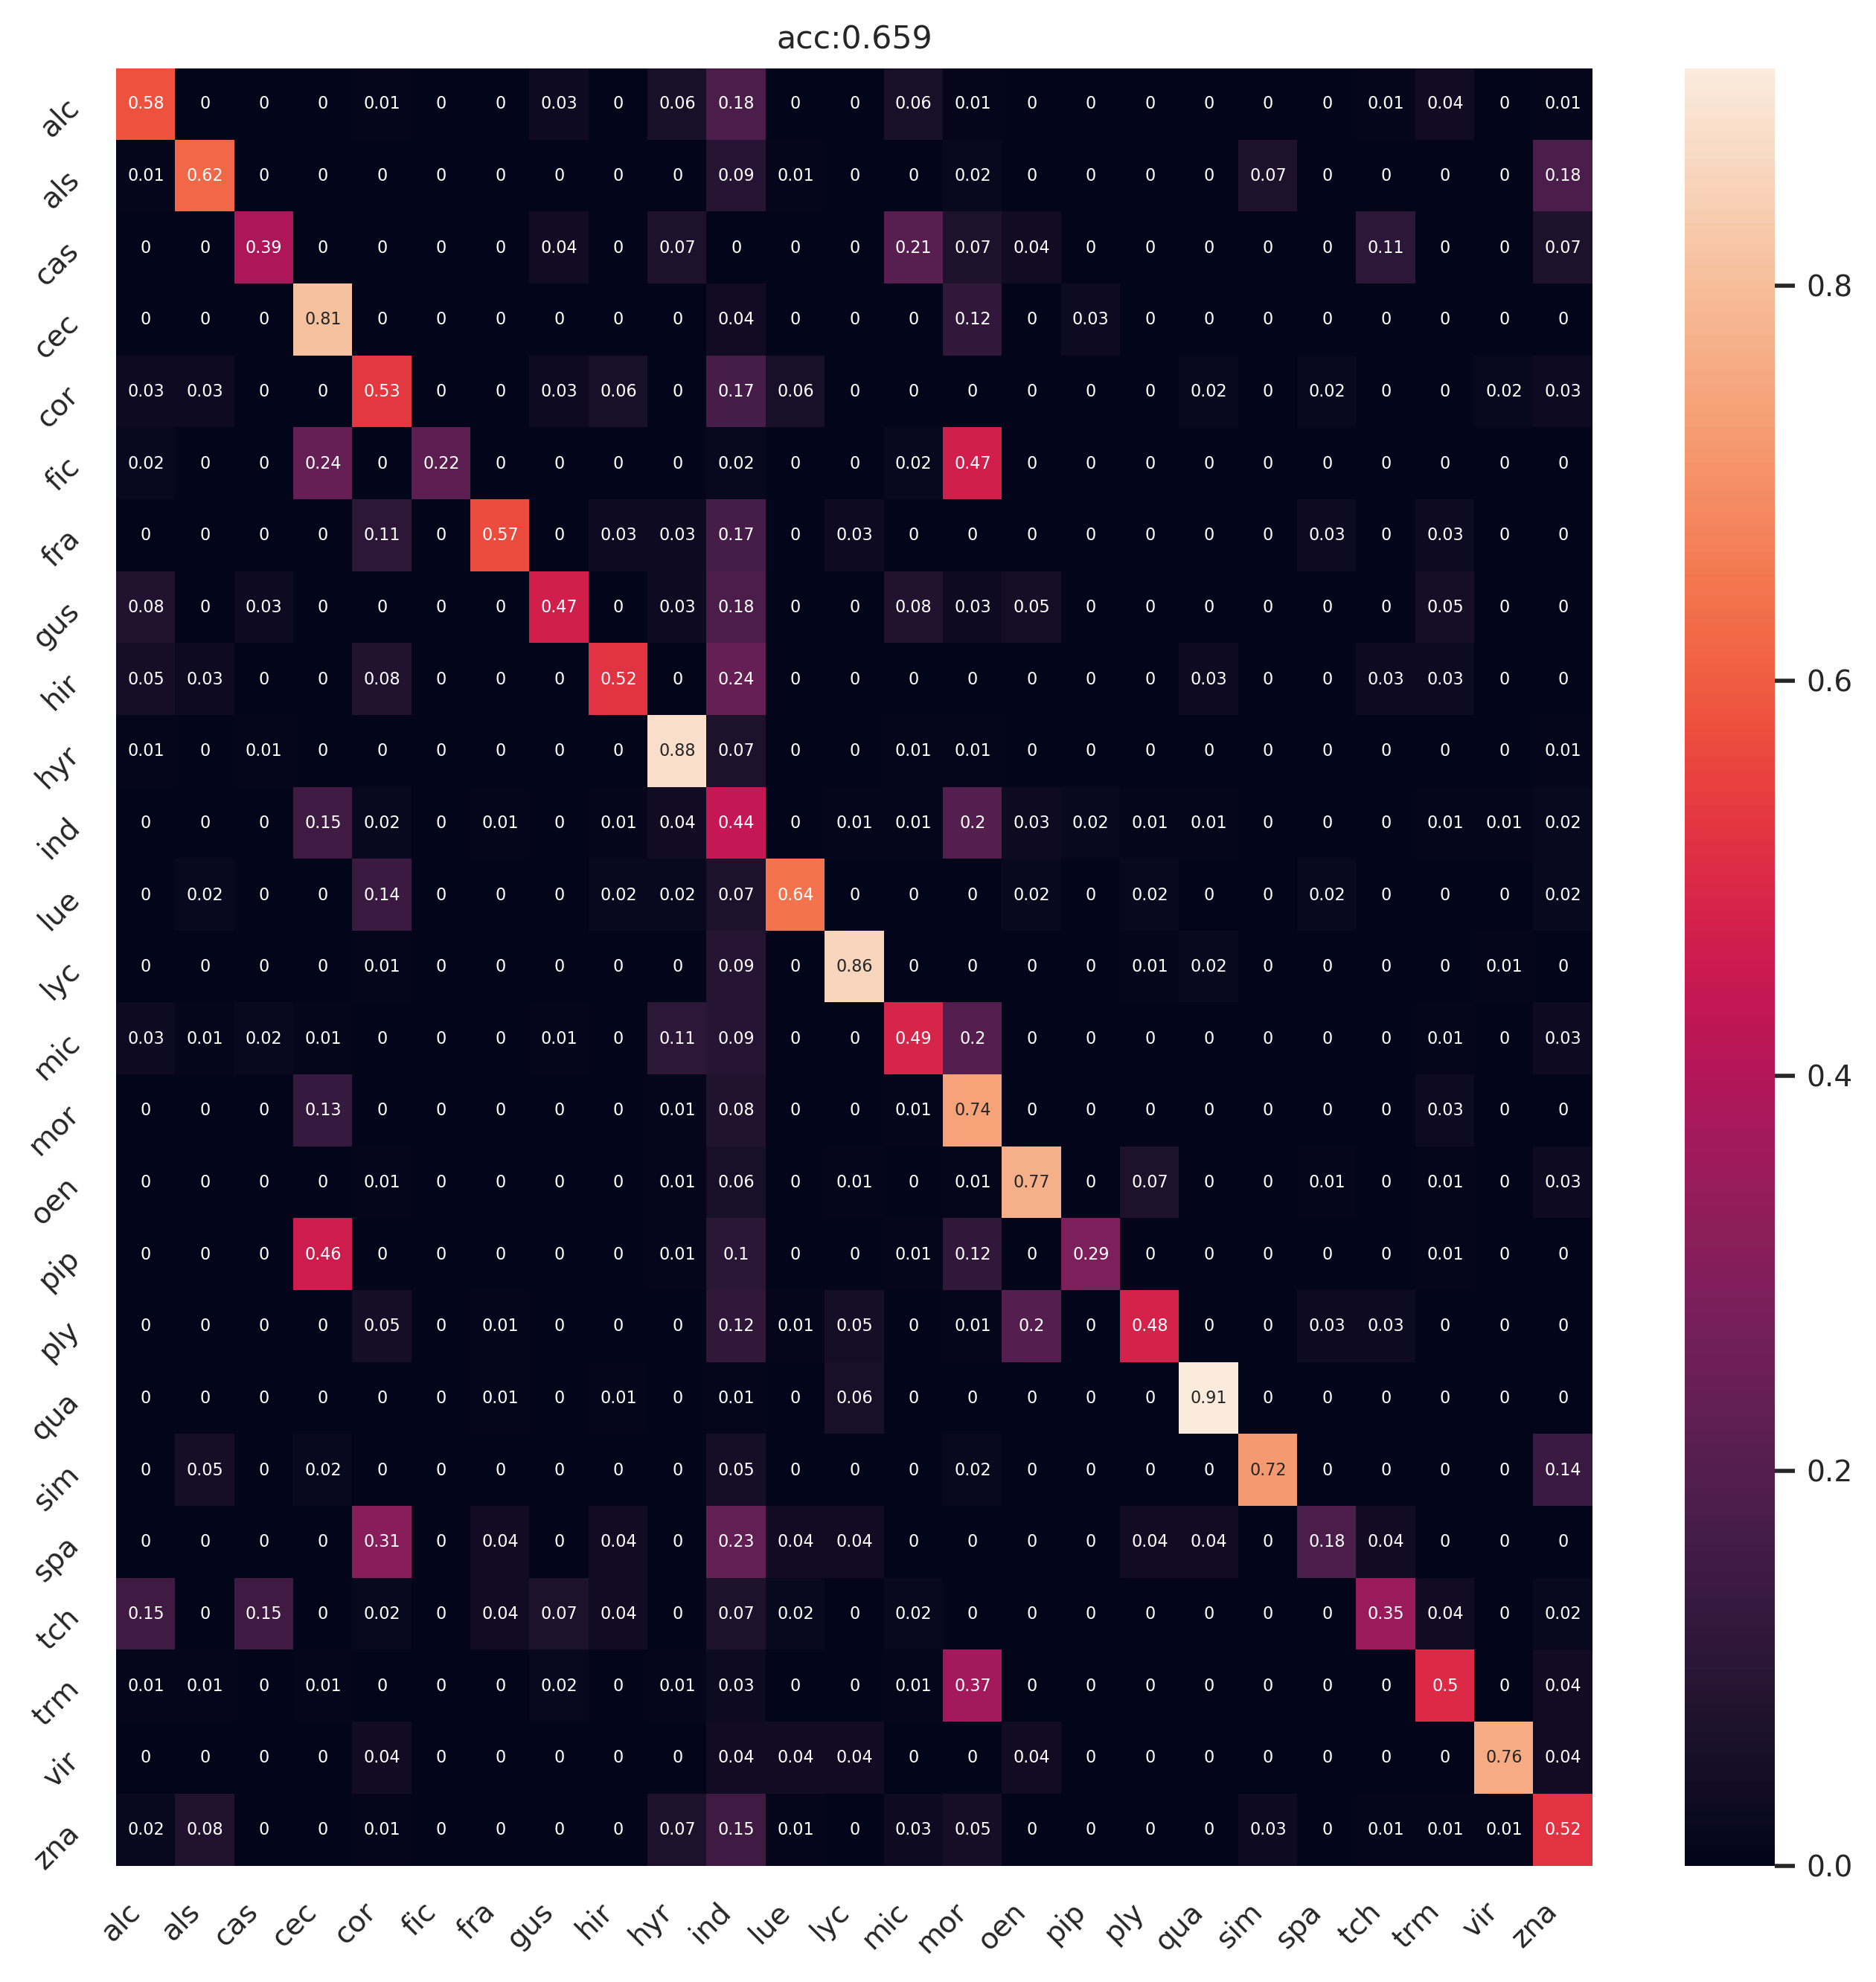

In [26]:
a = confMat.sum(axis=1).reshape((-1,1))
confMat = confMat / a
confMat = (confMat * 100).round()/100


plt.figure(figsize=(10, 10), dpi=320, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
nameList = itemgetter(*top25indices.numpy().tolist())(dbinfo['meta'])
df_cm = pd.DataFrame(confMat, nameList, nameList)

#df_cm.plot(kind='bar',alpha=0.75, rot=0)

#plt.figure(figsize = (10,7))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 5})# font size


# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.title('acc:{:.3f}'.format(acc))
plt.savefig(path.join('./result', project_name+'_top25.png'), dpi=320)

plt.show() # ta-da!



Leaving Blank
-----